<p style="font-size:32px; font-weight:bold">Brain Tumor MRI Classification Model</p>

# Import Library

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset
from PIL import Image
from skorch import NeuralNetClassifier
import skorch
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint, loguniform

import warnings
warnings.filterwarnings(action='ignore')

# Define configurations

In [2]:
CONFIG = {
    'batch_size' : 16,
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'epoch' : 25,
    'dataset_filepath_train' : '../../data/csv/train.csv',
    'dataset_filepath_test' : '../../data/csv/test.csv',
    'num_classes' : 4,
    'patience': 5
}

if torch.cuda.is_available():
    print(f"Using GPU")
else:
    print(f"Using CPU")

Using GPU


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.25),
    transforms.RandomRotation(degrees = 20),
    transforms.ColorJitter(                               
        brightness=0.3, 
        contrast=0.3, 
        saturation=0.3, 
        hue=0.1
    ),
    transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Define the DataLoader

In [4]:
class BrainDataset(Dataset):
    def __init__(self, csv_file: str, transform: transforms):
        try:
            self.__data = pd.read_csv(csv_file)
        except FileNotFoundError:
            print(f"File not found: {csv_file}")
            return
        
        self.__transform = transform
        self.__classes = sorted(self.__data['class_name'].unique())
        self.__class_label = {cls: idx for idx, cls in enumerate(self.__classes)}

    def __len__(self):
        return len(self.__data)

    def __getitem__(self, index):
        img_path = self.__data.iloc[index, 0]
        img_label_name = self.__data.iloc[index, 2]
        img_label = self.__class_label[img_label_name]

        image = Image.open(img_path).convert("RGB")

        if self.__transform:
            img = self.__transform(image)

        return img, img_label

In [5]:
train_dataset = BrainDataset(csv_file=CONFIG['dataset_filepath_train'], transform=transform)
test_dataset = BrainDataset(csv_file=CONFIG['dataset_filepath_test'], transform=transform)

In [6]:
train_data, val_data = random_split(train_dataset, [0.8, 0.2])

In [7]:
train_loader = DataLoader(dataset=train_data, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.1489761].


torch.Size([16, 3, 224, 224])
torch.Size([16])
tensor([1, 2, 3, 0, 3, 3, 2, 0, 2, 1, 2, 2, 0, 2, 3, 1])


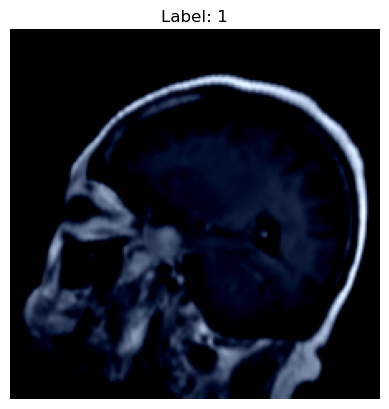


There are 286 training data batches
There are 72 validation data batches
There are 82 testing data batches


In [8]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label)

    img_single = img[0]

    img_np = img_single.cpu().numpy()

    # Rearrange dimensions from [C, H, W] → [H, W, C]
    img_np = img_np.transpose((1, 2, 0))

    img_np = (img_np * 0.5) + 0.5  # example for [-1,1] range

    plt.imshow(img_np)
    plt.title(f"Label: {label[0].item()}")
    plt.axis("off")
    plt.show()

    break

print()

print(f"There are {len(train_loader)} training data batches")
print(f"There are {len(val_loader)} validation data batches")
print(f"There are {len(test_loader)} testing data batches") 

# Initialize the model

In [9]:
class Model(torch.nn.Module):
    def __init__(self, dropout1=0.2, dropout2=0.1, hidden1=1024, hidden2=256, hidden3=128, out1=32, out2=64, dropout3=0.5):
        super().__init__()
        self.layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=out1, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout1)
        )
        self.layer_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout2)
        )
        self.flatten = torch.nn.Flatten()
        self.fc_layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=out2 * (out2 - 8) * (out2 - 8), out_features=hidden1),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden1, out_features=hidden2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout3),
            torch.nn.Linear(in_features=hidden2, out_features=hidden3),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden3, out_features=CONFIG['num_classes'])
        )

    def forward(self, x):
        x = self.layer_1(x)  
        x = self.layer_2(x)
        x = self.flatten(x)
        x = self.fc_layer(x)
        return x

# Training and Validation

## Define helper function to calculate each class weights

In [10]:
class_names = ["glioma", "meningioma", "notumor", "pituitary"] 

In [11]:
def compute_class_weights(loader, num_classes, device):
    print(f"Computing class weight...\n")
    counts = Counter()

    for _, labels in tqdm(loader, desc=f"Loading the labels"):
        counts.update(labels.tolist())

    total = sum(counts.values())

    # weight = total / class_count
    weights = torch.tensor(
        [total / counts[i] for i in range(num_classes)],
        dtype=torch.float32,
        device=device
    )

    print("\nClass Weights:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {weights[i].item():.4f}   (count = {counts[i]})")

    return weights

## Training and validation loop

In [12]:
brain_clas_model = Model().to(CONFIG['device'])

train_loss_arr = []
val_loss_arr = []
val_acc_arr = []
train_acc_arr = []

best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

num_classes = 4  # glioma, meningioma, notumor, pituitary
class_weights = compute_class_weights(train_loader, num_classes, CONFIG['device'])

loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(brain_clas_model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(CONFIG['epoch']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epoch']}")
    brain_clas_model.train()
    loss_sum = 0
    total = 0
    correct = 0

    train_pbar = tqdm(train_loader, desc=f"Train {epoch+1}")
    for img, label in train_pbar:
        X = img.to(CONFIG['device'])
        y = label.to(CONFIG['device'])

        optimizer.zero_grad()
        outputs = brain_clas_model(X)
        loss = loss_func(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_train_loss = loss_sum / len(train_loader)
    epoch_train_acc = correct / total
    train_loss_arr.append(epoch_train_loss)
    train_acc_arr.append(epoch_train_acc)

    val_loss_sum = 0
    total = 0
    correct = 0
    brain_clas_model.eval()

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Validate {epoch+1}")
        for img, label in val_pbar:
            X = img.to(CONFIG['device'])
            y = label.to(CONFIG['device'])

            outputs = brain_clas_model(X)

            loss = loss_func(outputs, y)
            val_loss_sum += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader)
    epoch_val_acc = correct / total

    val_loss_arr.append(epoch_val_loss)
    val_acc_arr.append(epoch_val_acc)

    tqdm.write(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc*100:.2f}% | "
        f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc*100:.2f}%"
    )

    
    # early stopping mechanism
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_state = brain_clas_model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve ({epochs_no_improve}/{CONFIG['patience']})")

        if epochs_no_improve >= CONFIG['patience']:
            print("\nEarly stopping triggered.")
            break

# restore the best model weights
if best_model_state:
    brain_clas_model.load_state_dict(best_model_state)
    print("Best model weights restored.")

Computing class weight...



Loading the labels: 100%|██████████| 286/286 [00:23<00:00, 11.99it/s]



Class Weights:
glioma: 4.3359   (count = 1054)
meningioma: 4.2992   (count = 1063)
notumor: 3.5399   (count = 1291)
pituitary: 3.9329   (count = 1162)

Epoch 1/25


Validate 1: 100%|██████████| 72/72 [00:06<00:00, 10.81it/s]


Epoch 001 | Train Loss: 1.1923, Acc: 51.68% | Val Loss: 0.9140, Acc: 61.65%

Epoch 2/25


Validate 2: 100%|██████████| 72/72 [00:06<00:00, 10.81it/s]


Epoch 002 | Train Loss: 0.8563, Acc: 65.10% | Val Loss: 0.8008, Acc: 67.86%

Epoch 3/25


Validate 3: 100%|██████████| 72/72 [00:06<00:00, 10.85it/s]


Epoch 003 | Train Loss: 0.7822, Acc: 69.28% | Val Loss: 0.7574, Acc: 69.18%

Epoch 4/25


Validate 4: 100%|██████████| 72/72 [00:06<00:00, 10.84it/s]


Epoch 004 | Train Loss: 0.7449, Acc: 70.74% | Val Loss: 0.7805, Acc: 69.70%
Validation loss did not improve (1/5)

Epoch 5/25


Validate 5: 100%|██████████| 72/72 [00:06<00:00, 10.84it/s]


Epoch 005 | Train Loss: 0.6813, Acc: 73.26% | Val Loss: 0.6859, Acc: 73.20%

Epoch 6/25


Validate 6: 100%|██████████| 72/72 [00:06<00:00, 10.80it/s]


Epoch 006 | Train Loss: 0.6616, Acc: 74.22% | Val Loss: 0.6682, Acc: 74.78%

Epoch 7/25


Validate 7: 100%|██████████| 72/72 [00:06<00:00, 10.84it/s]


Epoch 007 | Train Loss: 0.6376, Acc: 76.50% | Val Loss: 0.6174, Acc: 76.97%

Epoch 8/25


Validate 8: 100%|██████████| 72/72 [00:06<00:00, 10.81it/s]


Epoch 008 | Train Loss: 0.6324, Acc: 75.05% | Val Loss: 0.5939, Acc: 76.09%

Epoch 9/25


Validate 9: 100%|██████████| 72/72 [00:06<00:00, 10.81it/s]


Epoch 009 | Train Loss: 0.6169, Acc: 77.07% | Val Loss: 0.6156, Acc: 76.80%
Validation loss did not improve (1/5)

Epoch 10/25


Validate 10: 100%|██████████| 72/72 [00:06<00:00, 10.86it/s]


Epoch 010 | Train Loss: 0.5982, Acc: 78.34% | Val Loss: 0.6265, Acc: 75.13%
Validation loss did not improve (2/5)

Epoch 11/25


Validate 11: 100%|██████████| 72/72 [00:06<00:00, 10.84it/s]


Epoch 011 | Train Loss: 0.5935, Acc: 77.64% | Val Loss: 0.6262, Acc: 76.80%
Validation loss did not improve (3/5)

Epoch 12/25


Validate 12: 100%|██████████| 72/72 [00:06<00:00, 10.86it/s]


Epoch 012 | Train Loss: 0.5918, Acc: 78.49% | Val Loss: 0.5834, Acc: 78.55%

Epoch 13/25


Validate 13: 100%|██████████| 72/72 [00:06<00:00, 10.86it/s]


Epoch 013 | Train Loss: 0.5497, Acc: 78.88% | Val Loss: 0.5589, Acc: 76.53%

Epoch 14/25


Validate 14: 100%|██████████| 72/72 [00:06<00:00, 10.75it/s]


Epoch 014 | Train Loss: 0.5449, Acc: 79.26% | Val Loss: 0.5469, Acc: 79.07%

Epoch 15/25


Validate 15: 100%|██████████| 72/72 [00:06<00:00, 10.80it/s]


Epoch 015 | Train Loss: 0.5179, Acc: 80.37% | Val Loss: 0.5201, Acc: 80.82%

Epoch 16/25


Validate 16: 100%|██████████| 72/72 [00:06<00:00, 10.82it/s]


Epoch 016 | Train Loss: 0.5225, Acc: 80.44% | Val Loss: 0.5671, Acc: 79.16%
Validation loss did not improve (1/5)

Epoch 17/25


Validate 17: 100%|██████████| 72/72 [00:06<00:00, 10.85it/s]


Epoch 017 | Train Loss: 0.5129, Acc: 80.98% | Val Loss: 0.6151, Acc: 79.60%
Validation loss did not improve (2/5)

Epoch 18/25


Validate 18: 100%|██████████| 72/72 [00:06<00:00, 10.80it/s]


Epoch 018 | Train Loss: 0.5155, Acc: 81.27% | Val Loss: 0.5284, Acc: 79.77%
Validation loss did not improve (3/5)

Epoch 19/25


Validate 19: 100%|██████████| 72/72 [00:06<00:00, 10.83it/s]


Epoch 019 | Train Loss: 0.4680, Acc: 83.11% | Val Loss: 0.4925, Acc: 82.66%

Epoch 20/25


Validate 20: 100%|██████████| 72/72 [00:06<00:00, 10.71it/s]


Epoch 020 | Train Loss: 0.4738, Acc: 83.37% | Val Loss: 0.4999, Acc: 82.14%
Validation loss did not improve (1/5)

Epoch 21/25


Validate 21: 100%|██████████| 72/72 [00:06<00:00, 10.81it/s]


Epoch 021 | Train Loss: 0.4645, Acc: 83.30% | Val Loss: 0.4644, Acc: 82.84%

Epoch 22/25


Validate 22: 100%|██████████| 72/72 [00:06<00:00, 10.87it/s]


Epoch 022 | Train Loss: 0.4540, Acc: 83.04% | Val Loss: 0.5071, Acc: 81.09%
Validation loss did not improve (1/5)

Epoch 23/25


Validate 23: 100%|██████████| 72/72 [00:06<00:00, 10.94it/s]


Epoch 023 | Train Loss: 0.4693, Acc: 83.70% | Val Loss: 0.4861, Acc: 82.84%
Validation loss did not improve (2/5)

Epoch 24/25


Validate 24: 100%|██████████| 72/72 [00:06<00:00, 10.84it/s]


Epoch 024 | Train Loss: 0.4359, Acc: 84.49% | Val Loss: 0.4477, Acc: 83.71%

Epoch 25/25


Validate 25: 100%|██████████| 72/72 [00:06<00:00, 11.08it/s]

Epoch 025 | Train Loss: 0.4352, Acc: 84.51% | Val Loss: 0.4287, Acc: 84.50%
Best model weights restored.


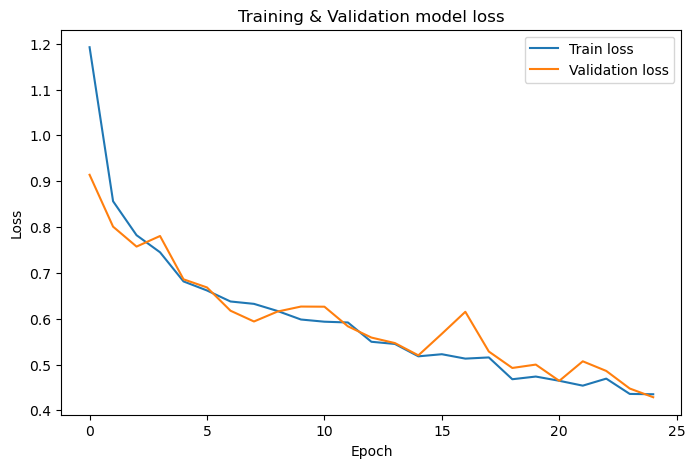

In [13]:
plt.figure(figsize=(8, 5))
plt.title(f"Training & Validation model loss")
plt.plot(train_loss_arr, label="Train loss")
plt.plot(val_loss_arr, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

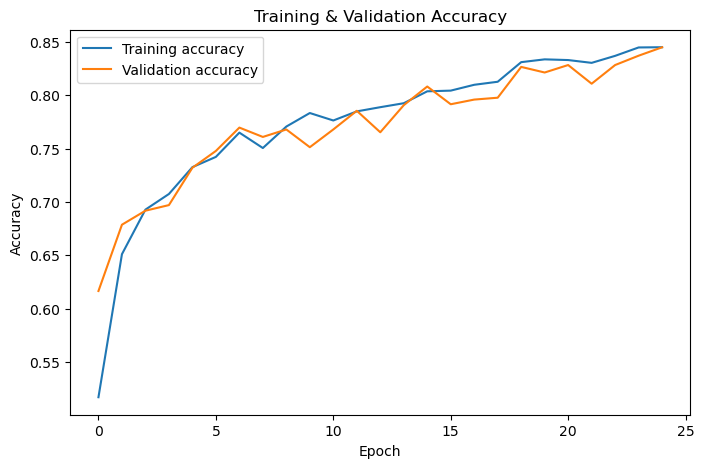

In [14]:
plt.figure(figsize=(8, 5))
plt.title("Training & Validation Accuracy")
plt.plot(train_acc_arr, label='Training accuracy')
plt.plot(val_acc_arr, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Hyperparameter Tuning

## Define the model to tune on & training datas

In [15]:
X_train, y_train = [], []

for inputs, labels in train_loader:
    X_train.append(inputs)
    y_train.append(labels)

# Concatenate all batches into single tensors
X_train = torch.cat(X_train)
y_train = torch.cat(y_train)

X_train = X_train.numpy()
y_train = y_train.numpy()

print(X_train.shape, y_train.shape)

(4570, 3, 224, 224) (4570,)


In [16]:
model_net = NeuralNetClassifier(
    Model,
    max_epochs=5,
    lr = 0.001,
    optimizer = torch.optim.Adam,
    criterion = torch.nn.CrossEntropyLoss,
    train_split= skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.GradientNormClipping(5.0)],
    device = CONFIG['device']
)

## Define parameters

In [20]:
params = {
    'module__dropout1': uniform(0.0, 0.3),
    'module__dropout2': uniform(0.0, 0.5),
    'module__dropout3': uniform(0.0, 0.7),
    'module__out1': [16, 32, 64, 128],
    'module__out2': [32, 64, 128, 256],
    'module__hidden1': [256, 512, 1024, 2048],
    'module__hidden2': [128, 256, 512],
    'module__hidden3': [64, 128, 256],
    'lr': loguniform(1e-5, 1e-2),
    'max_epochs': randint(5, 51),
}

## Hyperparameterization process

In [21]:
scorer = make_scorer(score_func=accuracy_score, greater_is_better=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
search = RandomizedSearchCV(
    estimator=model_net,
    param_distributions=params,
    n_iter=5,
    scoring=scorer,
    cv=cv,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END lr=0.0001329291894316216, max_epochs=33, module__dropout1=0.05503043695984914, module__dropout2=0.38984550013638464, module__dropout3=0.4177951105625409, module__hidden1=512, module__hidden2=512, module__hidden3=256, module__out1=64, module__out2=128; total time=   3.5s
[CV] END lr=0.0001329291894316216, max_epochs=33, module__dropout1=0.05503043695984914, module__dropout2=0.38984550013638464, module__dropout3=0.4177951105625409, module__hidden1=512, module__hidden2=512, module__hidden3=256, module__out1=64, module__out2=128; total time=   3.7s
[CV] END lr=0.0001329291894316216, max_epochs=33, module__dropout1=0.05503043695984914, module__dropout2=0.38984550013638464, module__dropout3=0.4177951105625409, module__hidden1=512, module__hidden2=512, module__hidden3=256, module__out1=64, module__out2=128; total time=   3.5s
[CV] END lr=0.0001329291894316216, max_epochs=33, module__dropout1=0.05503043695984914, module__drop

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","<class 'skorc...n__.Model'>, )"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'lr': <scipy.stats....00268DD239510>, 'max_epochs': <scipy.stats....0026838500D10>, 'module__dropout1': <scipy.stats....002698A0E61D0>, 'module__dropout2': <scipy.stats....00268DD2F4290>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",5
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(a...hod='predict')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refe

In [23]:
print("Best parameters found:")
print(search.best_params_)

print("Best CV accuracy:")
print(search.best_score_)

Best parameters found:
{'lr': np.float64(0.0006647135865318024), 'max_epochs': 25, 'module__dropout1': np.float64(0.1351497755908629), 'module__dropout2': np.float64(0.006632480579933264), 'module__dropout3': np.float64(0.6595412289793969), 'module__hidden1': 512, 'module__hidden2': 256, 'module__hidden3': 128, 'module__out1': 16, 'module__out2': 64}
Best CV accuracy:
0.6772428884026258


# Retrain model on new parameters

In [24]:
best_params = search.best_params_

In [25]:
brain_clas_model = Model(
    hidden1=best_params['module__hidden1'],
    hidden2=best_params['module__hidden2'],
    hidden3=best_params['module__hidden3'],
    dropout1=best_params['module__dropout1'],
    dropout2=best_params['module__dropout2'],
    dropout3=best_params['module__dropout3'],
    out1=best_params['module__out1'],
    out2=best_params['module__out2']
).to(CONFIG['device'])

In [26]:
train_loss_arr = []
val_loss_arr = []
val_acc_arr = []
train_acc_arr = []

best_val_loss = np.inf
epochs_no_improve = 0
best_model_state = None

num_classes = 4  # glioma, meningioma, notumor, pituitary
class_weights = compute_class_weights(train_loader, num_classes, CONFIG['device'])

loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(brain_clas_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)

for epoch in range(best_params['max_epochs']):
    print(f"\nEpoch {epoch+1}/{best_params['max_epochs']}")
    brain_clas_model.train()
    loss_sum = 0
    total = 0
    correct = 0

    train_pbar = tqdm(train_loader, desc=f"Train {epoch+1}")
    for img, label in train_pbar:
        X = img.to(CONFIG['device'])
        y = label.to(CONFIG['device'])

        optimizer.zero_grad()
        outputs = brain_clas_model(X)
        loss = loss_func(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_train_loss = loss_sum / len(train_loader)
    epoch_train_acc = correct / total
    train_loss_arr.append(epoch_train_loss)
    train_acc_arr.append(epoch_train_acc)

    val_loss_sum = 0
    total = 0
    correct = 0
    brain_clas_model.eval()

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Validate {epoch+1}")
        for img, label in val_pbar:
            X = img.to(CONFIG['device'])
            y = label.to(CONFIG['device'])

            outputs = brain_clas_model(X)

            loss = loss_func(outputs, y)
            val_loss_sum += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader)
    epoch_val_acc = correct / total

    val_loss_arr.append(epoch_val_loss)
    val_acc_arr.append(epoch_val_acc)

    tqdm.write(
        f"Epoch {epoch+1:03d} | "
        f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc*100:.2f}% | "
        f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc*100:.2f}%"
    )

    # early stopping mechanism
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        best_model_state = brain_clas_model.state_dict()
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve ({epochs_no_improve}/{CONFIG['patience']})")

        if epochs_no_improve >= CONFIG['patience']:
            print("\nEarly stopping triggered.")
            break

# restore the best model weights
if best_model_state is not None:
    brain_clas_model.load_state_dict(best_model_state)
    print("Best model weights restored.")

Computing class weight...



Loading the labels: 100%|██████████| 286/286 [00:24<00:00, 11.49it/s]



Class Weights:
glioma: 4.3359   (count = 1054)
meningioma: 4.2992   (count = 1063)
notumor: 3.5399   (count = 1291)
pituitary: 3.9329   (count = 1162)

Epoch 1/25


Validate 1: 100%|██████████| 72/72 [00:06<00:00, 11.08it/s]


Epoch 001 | Train Loss: 1.1756, Acc: 50.44% | Val Loss: 0.9888, Acc: 57.71%

Epoch 2/25


Validate 2: 100%|██████████| 72/72 [00:06<00:00, 11.03it/s]


Epoch 002 | Train Loss: 0.8283, Acc: 67.42% | Val Loss: 0.8024, Acc: 68.30%

Epoch 3/25


Validate 3: 100%|██████████| 72/72 [00:06<00:00, 11.19it/s]


Epoch 003 | Train Loss: 0.7539, Acc: 70.18% | Val Loss: 0.7137, Acc: 73.29%

Epoch 4/25


Validate 4: 100%|██████████| 72/72 [00:06<00:00, 11.18it/s]


Epoch 004 | Train Loss: 0.7035, Acc: 72.45% | Val Loss: 0.6743, Acc: 74.69%

Epoch 5/25


Validate 5: 100%|██████████| 72/72 [00:06<00:00, 11.21it/s]


Epoch 005 | Train Loss: 0.6461, Acc: 75.21% | Val Loss: 0.6933, Acc: 72.50%
Validation loss did not improve (1/5)

Epoch 6/25


Validate 6: 100%|██████████| 72/72 [00:06<00:00, 11.21it/s]


Epoch 006 | Train Loss: 0.6377, Acc: 76.06% | Val Loss: 0.6329, Acc: 74.61%

Epoch 7/25


Validate 7: 100%|██████████| 72/72 [00:06<00:00, 11.15it/s]


Epoch 007 | Train Loss: 0.6028, Acc: 76.76% | Val Loss: 0.5712, Acc: 77.58%

Epoch 8/25


Validate 8: 100%|██████████| 72/72 [00:06<00:00, 11.21it/s]


Epoch 008 | Train Loss: 0.5618, Acc: 78.67% | Val Loss: 0.5868, Acc: 78.55%
Validation loss did not improve (1/5)

Epoch 9/25


Validate 9: 100%|██████████| 72/72 [00:06<00:00, 11.22it/s]


Epoch 009 | Train Loss: 0.5452, Acc: 79.74% | Val Loss: 0.5639, Acc: 78.72%

Epoch 10/25


Validate 10: 100%|██████████| 72/72 [00:06<00:00, 11.17it/s]


Epoch 010 | Train Loss: 0.5203, Acc: 80.85% | Val Loss: 0.5039, Acc: 80.65%

Epoch 11/25


Validate 11: 100%|██████████| 72/72 [00:06<00:00, 11.22it/s]


Epoch 011 | Train Loss: 0.4910, Acc: 82.08% | Val Loss: 0.4853, Acc: 83.19%

Epoch 12/25


Validate 12: 100%|██████████| 72/72 [00:06<00:00, 11.21it/s]


Epoch 012 | Train Loss: 0.5021, Acc: 81.62% | Val Loss: 0.4921, Acc: 82.31%
Validation loss did not improve (1/5)

Epoch 13/25


Validate 13: 100%|██████████| 72/72 [00:06<00:00, 11.16it/s]


Epoch 013 | Train Loss: 0.4600, Acc: 83.26% | Val Loss: 0.4375, Acc: 84.15%

Epoch 14/25


Validate 14: 100%|██████████| 72/72 [00:06<00:00, 11.13it/s]


Epoch 014 | Train Loss: 0.4383, Acc: 84.33% | Val Loss: 0.4616, Acc: 83.54%
Validation loss did not improve (1/5)

Epoch 15/25


Validate 15: 100%|██████████| 72/72 [00:06<00:00, 11.13it/s]


Epoch 015 | Train Loss: 0.4460, Acc: 84.18% | Val Loss: 0.4941, Acc: 82.49%
Validation loss did not improve (2/5)

Epoch 16/25


Validate 16: 100%|██████████| 72/72 [00:06<00:00, 11.18it/s]


Epoch 016 | Train Loss: 0.4341, Acc: 84.27% | Val Loss: 0.4336, Acc: 83.80%

Epoch 17/25


Validate 17: 100%|██████████| 72/72 [00:06<00:00, 11.18it/s]


Epoch 017 | Train Loss: 0.4174, Acc: 84.77% | Val Loss: 0.4187, Acc: 84.33%

Epoch 18/25


Validate 18: 100%|██████████| 72/72 [00:06<00:00, 11.15it/s]


Epoch 018 | Train Loss: 0.4095, Acc: 85.19% | Val Loss: 0.4186, Acc: 84.76%

Epoch 19/25


Validate 19: 100%|██████████| 72/72 [00:06<00:00, 11.21it/s]


Epoch 019 | Train Loss: 0.3965, Acc: 85.16% | Val Loss: 0.4770, Acc: 82.22%
Validation loss did not improve (1/5)

Epoch 20/25


Validate 20: 100%|██████████| 72/72 [00:06<00:00, 11.18it/s]


Epoch 020 | Train Loss: 0.3934, Acc: 86.39% | Val Loss: 0.4430, Acc: 84.59%
Validation loss did not improve (2/5)

Epoch 21/25


Validate 21: 100%|██████████| 72/72 [00:06<00:00, 11.20it/s]


Epoch 021 | Train Loss: 0.3903, Acc: 86.24% | Val Loss: 0.4022, Acc: 85.90%

Epoch 22/25


Validate 22: 100%|██████████| 72/72 [00:06<00:00, 11.20it/s]


Epoch 022 | Train Loss: 0.3875, Acc: 86.52% | Val Loss: 0.4409, Acc: 84.33%
Validation loss did not improve (1/5)

Epoch 23/25


Validate 23: 100%|██████████| 72/72 [00:06<00:00, 11.14it/s]


Epoch 023 | Train Loss: 0.3651, Acc: 87.18% | Val Loss: 0.3727, Acc: 86.95%

Epoch 24/25


Validate 24: 100%|██████████| 72/72 [00:06<00:00, 11.19it/s]


Epoch 024 | Train Loss: 0.3516, Acc: 87.59% | Val Loss: 0.3879, Acc: 86.78%
Validation loss did not improve (1/5)

Epoch 25/25


Validate 25: 100%|██████████| 72/72 [00:06<00:00, 11.18it/s]

Epoch 025 | Train Loss: 0.3708, Acc: 86.96% | Val Loss: 0.3733, Acc: 86.16%
Validation loss did not improve (2/5)
Best model weights restored.


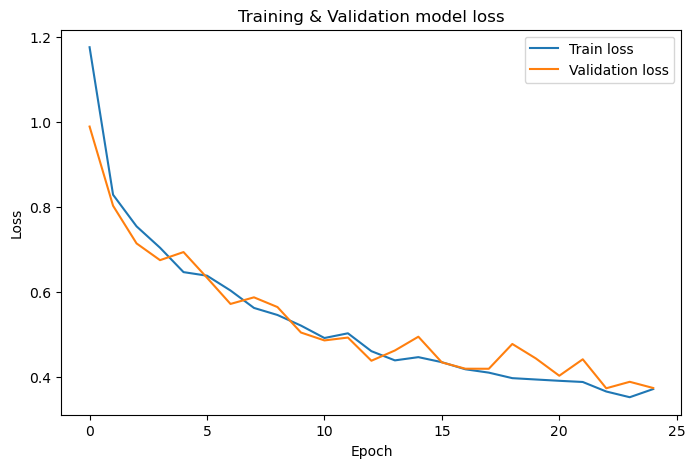

In [27]:
plt.figure(figsize=(8, 5))
plt.title(f"Training & Validation model loss")
plt.plot(train_loss_arr, label="Train loss")
plt.plot(val_loss_arr, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

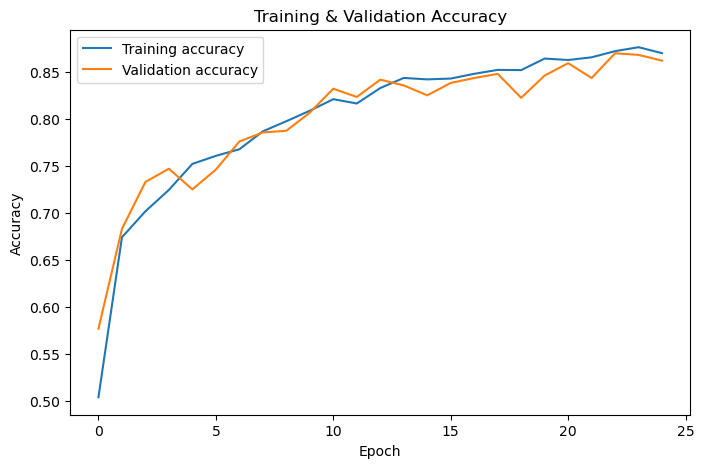

In [28]:
plt.figure(figsize=(8, 5))
plt.title("Training & Validation Accuracy")
plt.plot(train_acc_arr, label='Training accuracy')
plt.plot(val_acc_arr, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Testing the model

In [29]:
test_loss_sum = 0
total = 0
correct = 0
all_preds = []
all_labels = []
all_probs = []

brain_clas_model.eval()

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc=f"Validating...")
    for img, label in test_pbar:
        X = img.to(CONFIG['device'])
        y = label.to(CONFIG['device'])

        outputs = brain_clas_model(X)

        loss = loss_func(outputs, y)
        test_loss_sum += loss.item()

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

epoch_test_loss = test_loss_sum / len(test_loader)
epoch_test_acc = correct / total

print(f"Loss: {epoch_test_loss}")
print(f"Accuracy: {epoch_test_acc}")

Validating...: 100%|██████████| 82/82 [00:07<00:00, 11.15it/s]

Loss: 0.3889904557911838
Accuracy: 0.8482074752097636


# Evaluating the model

In [30]:
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

In [31]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Classification Report:

              precision    recall  f1-score   support

      glioma     0.9519    0.6600    0.7795       300
  meningioma     0.6905    0.7876    0.7359       306
     notumor     0.9034    0.9704    0.9357       405
   pituitary     0.8777    0.9333    0.9047       300

    accuracy                         0.8482      1311
   macro avg     0.8559    0.8378    0.8390      1311
weighted avg     0.8590    0.8482    0.8462      1311



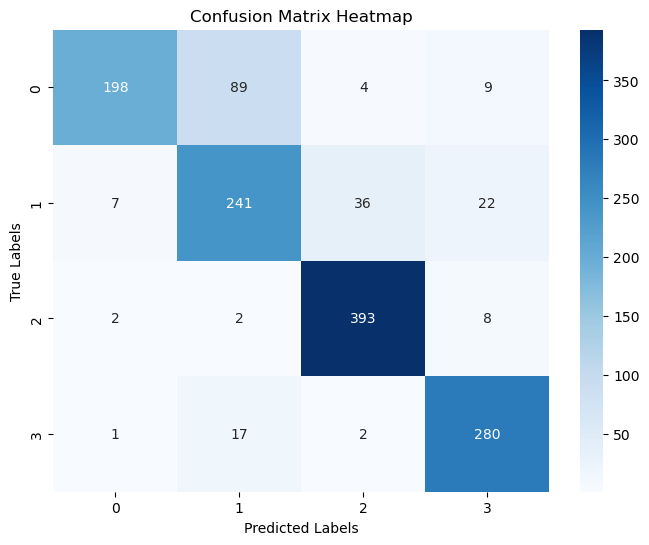

In [32]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(len(set(all_labels))),
            yticklabels=range(len(set(all_labels))))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [33]:
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix:\n")
print(cm_df)


Confusion Matrix:

            glioma  meningioma  notumor  pituitary
glioma         198          89        4          9
meningioma       7         241       36         22
notumor          2           2      393          8
pituitary        1          17        2        280


In [34]:
y_true = np.array(all_labels)
y_prob = np.array(all_probs)

n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

In [35]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc["macro"] = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
roc_auc["micro"] = roc_auc_score(y_true_bin, y_prob, average="micro", multi_class="ovr")

print("\nROC-AUC Scores:")
for i, name in enumerate(class_names):
    print(f"{name}: {roc_auc[i]:.4f}")
print(f"Macro ROC-AUC: {roc_auc['macro']:.4f}")
print(f"Micro ROC-AUC: {roc_auc['micro']:.4f}")


ROC-AUC Scores:
glioma: 0.9773
meningioma: 0.9139
notumor: 0.9916
pituitary: 0.9890
Macro ROC-AUC: 0.9679
Micro ROC-AUC: 0.9727


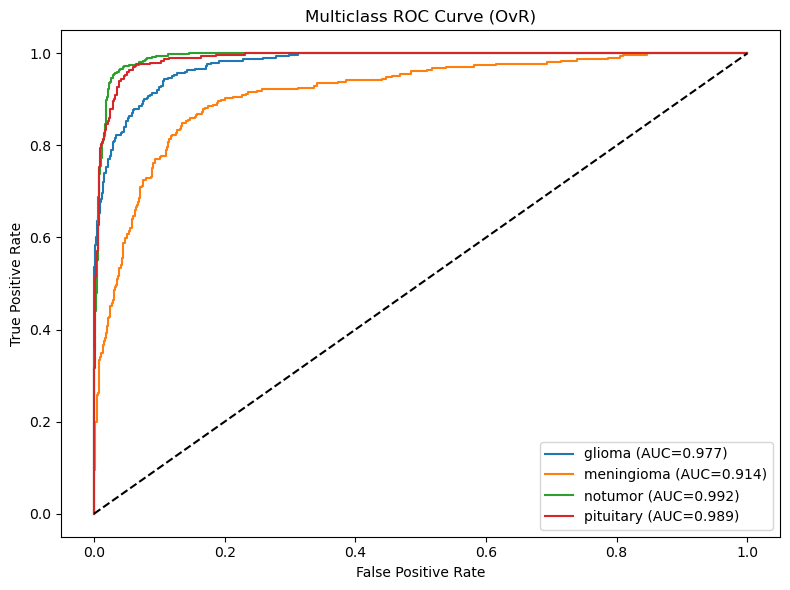

In [36]:
plt.figure(figsize=(8,6))
for i, name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC={roc_auc[i]:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (OvR)")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
precision = {}
recall = {}
avg_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

avg_precision["macro"] = average_precision_score(y_true_bin, y_prob, average="macro")
avg_precision["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

print("\nPR-AUC Scores:")
for i, name in enumerate(class_names):
    print(f"{name}: {avg_precision[i]:.4f}")
print(f"Macro PR-AUC: {avg_precision['macro']:.4f}")
print(f"Micro PR-AUC: {avg_precision['micro']:.4f}")


PR-AUC Scores:
glioma: 0.9380
meningioma: 0.7972
notumor: 0.9785
pituitary: 0.9630
Macro PR-AUC: 0.9192
Micro PR-AUC: 0.9276


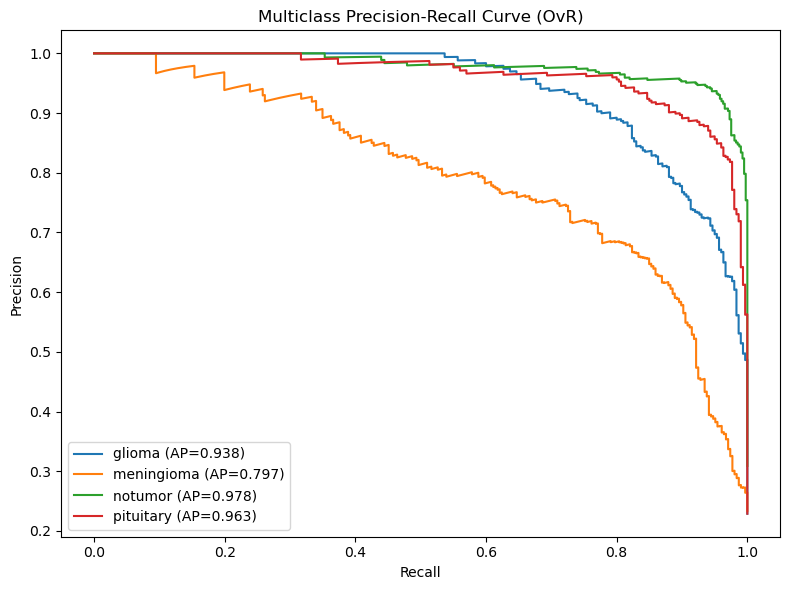

In [38]:
plt.figure(figsize=(8,6))
for i, name in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=f"{name} (AP={avg_precision[i]:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multiclass Precision-Recall Curve (OvR)")
plt.legend()
plt.tight_layout()
plt.show()

# Saving the model

In [42]:
model_architecture = {
    'state_dict': brain_clas_model.state_dict(),
    'config': {
        'hidden1' : best_params['module__hidden1'],
        'hidden2' : best_params['module__hidden2'],
        'hidden3' : best_params['module__hidden3'],
        'dropout1' : best_params['module__dropout1'],
        'dropout2' : best_params['module__dropout2'],
        'dropout3' : best_params['module__dropout3'],
        'out1' : best_params['module__out1'],
        'out2' : best_params['module__out2']
    }
}

torch.save(model_architecture, "../../model/brain_tumor_classifier.pth")